# CIFAR-10 Classifier Documentation using CNN

Author: Filip Gębala

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from collections import Counter

<h2>Model CNN</h2>

A Convolutional Neural Network (CNN) is a type of feedforward neural network that learns meaningful data features by optimizing filters (also called convolutional kernels). CNNs are widely used in various domains—from image analysis, through text processing, to audio data. In image analysis, CNNs have become the standard solution for computer vision and image processing tasks.

The model is based on four convolutional layers, each designed to extract increasingly complex image features. Input data (RGB images from CIFAR-10) first pass through a convolutional layer with 64 filters, followed by batch normalization and a ReLU activation. A max pooling operation then reduces dimensions while preserving key information. This pattern repeats in subsequent layers with 128, 256, and 512 filters.

After the last convolutional layer, a global average pooling layer reduces each feature map to a single value, significantly decreasing the number of parameters before the fully connected layer. Before the classifier, a dropout layer with probability 0.5 helps prevent overfitting. Final classification is performed by a single linear layer that outputs 10 values corresponding to the CIFAR-10 classes. The entire model is trained using the Adam optimizer with weight decay and a learning rate scheduler that decreases the rate over time to improve training stability.

In [3]:
# === MODEL ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

<h2>Data Preparation</h2>

Before training, data must be appropriately processed. For the training set, data augmentation includes random cropping with padding and random horizontal flips. This exposes the network to diverse image variants and improves generalization. Afterwards, images are converted to tensors and normalized so that each color channel (R, G, B) has the mean and standard deviation of the CIFAR-10 dataset. For the test set, only normalization is applied.

In [4]:
# === TRANSFORMATIONS ===
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                 
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

<h2>Data Loading and Model Initialization</h2>

After loading data into DataLoaders, the model and the Adam optimizer are initialized. L2 regularization (weight decay) is applied to limit overfitting. A scheduler reduces the learning rate by half every 10 epochs to help convergence in later training stages. The loss function is CrossEntropyLoss, suitable for multi-class classification.

In [6]:
# === DATA LOADING ===
trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="../data", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# === MODEL & OPTIMIZER ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

100%|██████████| 170M/170M [00:11<00:00, 15.0MB/s] 


Using device: cpu


## Data visualisation and analysis

In [14]:
print("Number of images in the training set:", len(trainset))
print("Number of images in the test set:", len(testset))
print("Number of classes:", len(trainset.classes))
print("Class names:", trainset.classes)

# Class distribution in the training and test sets

train_labels = [label for _, label in trainset]
test_labels = [label for _, label in testset]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("\nClass distribution in the training set:")
for idx, cls in enumerate(trainset.classes):
    print(f"{cls}: {train_counts[idx]}")

print("\nClass distribution in the test set:")
for idx, cls in enumerate(testset.classes):
    print(f"{cls}: {test_counts[idx]}")

# Example image shape:
img, _ = trainset[0]
print("\nImage shape:", img.shape)

Number of images in the training set: 50000
Number of images in the test set: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class distribution in the training set:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000

Class distribution in the test set:
airplane: 1000
automobile: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000

Image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7207834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7793142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6116571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8573554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8183348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7500488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

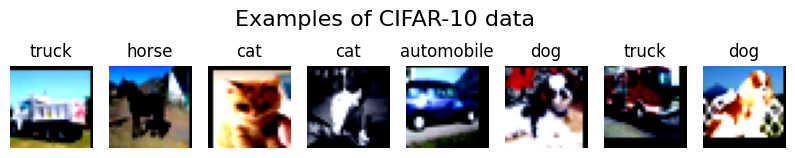

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 2)) 
for i in range(8): 
    plt.subplot(1, 8, i+1)
    imshow(images[i])
    plt.title(trainset.classes[labels[i]])
plt.suptitle("Examples of CIFAR-10 data", fontsize=16)
plt.show()

<h2>Model training</h2>

The training process is divided into epochs. In each epoch, the model iterates over all batches in the training set. For each batch, predictions are made, the loss is computed, and an optimization step is performed. At the end of each epoch, the model is evaluated on the test set. Training losses, test accuracies, and confusion matrices are recorded for analysis.

In [ ]:
# === TRAINING ===

def train_model(model, trainloader, testloader, optimizer, scheduler, criterion, device, epochs):
    train_losses, test_accuracies, confusion_matrices = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        train_losses.append(avg_loss)

        # Evaluate model and get confusion matrix
        accuracy, cm = test_model(model, testloader, device, return_confusion=True)
        test_accuracies.append(accuracy)
        confusion_matrices.append(cm)  # Store confusion matrix

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies, confusion_matrices

# === EXECUTION ===
train_losses, test_accuracies, confusion_matrices = train_model(
    model, trainloader, testloader, optimizer, scheduler, criterion, device, epochs=30
)

<h2>Model testing </h2>

The test_model function switches the model to evaluation mode—disabling gradient calculation and dropout. It computes predictions for the test set, calculates accuracy, and optionally returns the confusion matrix.

In [ ]:
# === TEST ===
def test_model(model, testloader, device, return_confusion=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    if return_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        return accuracy, cm
    return accuracy

<h2> Plots </h2>

At the end, three plots are generated: one showing the training loss over epochs, second one showing the test accuracy and the third one being a confussion matrix. This helps to evaluate models performance.

In [1]:
# === PLOTS ===
epochs_range = range(1, len(train_losses)+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[-1], display_labels=testset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Final Confusion Matrix')
plt.show()

NameError: name 'train_losses' is not defined